In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import (
    FitzHughNagumoProcess,
    FitzHughNagumoAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.models import neurb, pCN
from neuralbridge.utils.plotting import plot_sample_path

### Conditioning on normal event

Neural bridge

In [75]:
config = read_config("../configs/fhn_normal.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

{'sde': {'dim': 2, 'T': 2.0, 'dt': 0.005, 'params_X': {'chi': 0.1, 's': 0.0, 'gamma': 1.5, 'alpha': 0.8, 'sigma': 0.3}, 'params_X_tilde': {'chi': 0.1, 's': 0.0, 'gamma': 1.5, 'alpha': 0.8, 'sigma': 0.3, 'v': -1.0}, 'u': [-0.5, -0.6], 'v': [-1.0, nan], 'eps': 0.0001}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [32, 32, 32, 32], 'activation': 'tanh'}, 'training': {'save_name': 'fhn_model_normal_partial_obs', 'learning_rate': 0.0005, 'batch_size': 32, 'n_iters': 500, 'n_epochs': 15, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


unconditional process plotting

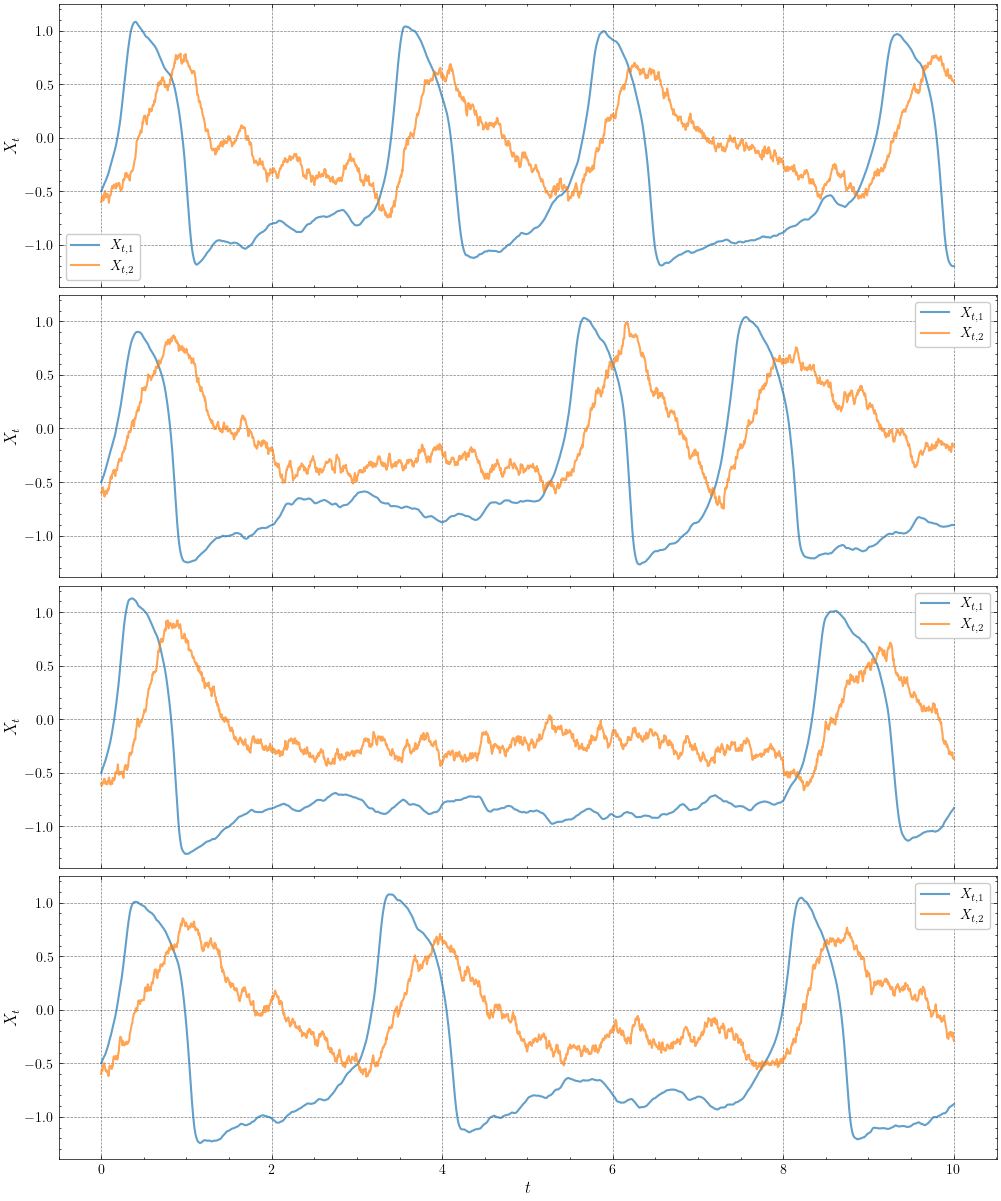

In [62]:
W = WienerProcess(
    T=10.0,
    dt=config.sde.dt,
    shape=(1, )
)

X = FitzHughNagumoProcess(
    params=config.sde.params_X,
    T=10.0,
    dim=config.sde.dim
)

X_solver = Euler(X, W)
X_path = X_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=4)
fig, ax = plt.subplots(4, 1, figsize=(10, 12), layout="constrained", sharex=True, sharey=True)
for i in range(4):
    plot_sample_path(X_path[i], ax=ax[i], label=[r"$X_{t, 1}$", r"$X_{t, 2}$"], linewidth=1.5)
    ax[i].set_ylabel(r"$X_t$", fontsize=12)
    ax[i].legend()
ax[3].set_xlabel(r"$t$", fontsize=12)
fig.savefig("../assets/figures/fhn_model/unconditional.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [63]:
W = WienerProcess(
    T=config.sde.T,
    dt=config.sde.dt,
    shape=(config.sde.dim, )
)

X = FitzHughNagumoProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde = FitzHughNagumoAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt),
)
X_diamond = neurb.NeuralBridge(
    X_circ=X_circ,
    config=config
)

X_diamond.initialize_solver(W)
_ = X_diamond.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_diamond_path = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=16)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/fhn_model_normal_partial_obs
INFO:root:Loading pretrained model from the last epoch


Pre-conditioned Crank-Nicolson

In [52]:
config = {
    "rho": 0.0,
    "batch_size": 8,
    "n_iters": 50000
}
pCN_model = pCN.PreconditionedCrankNicolson(
    X_circ=X_circ,
    config=config
)
pCN_model.initialize_solver(W)
_, pCN_result = pCN_model.run()
X_star_pCN_path = pCN_result.path

Running pCN: 100%|██████████| 50000/50000 [00:45<00:00, 1099.03it/s]
INFO:root:Batch average acceptance rate: 61.77%


Brutal force sampling to obtain the "ground truth"

In [76]:
X_solver = Euler(X, W)
X_path = X_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=10000)
# Create masks for each component's end point conditions
x1_mask = (X_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_path.xs[:, -1, 0] <= v[0] + 1e-2)
final_mask = x1_mask
X_star_path = X_path[final_mask]
print(f"Found {X_star_path.n_samples} samples that satisfy the endpoint conditions out of {X_path.n_samples} samples")

Found 454 samples that satisfy the endpoint conditions out of 10000 samples


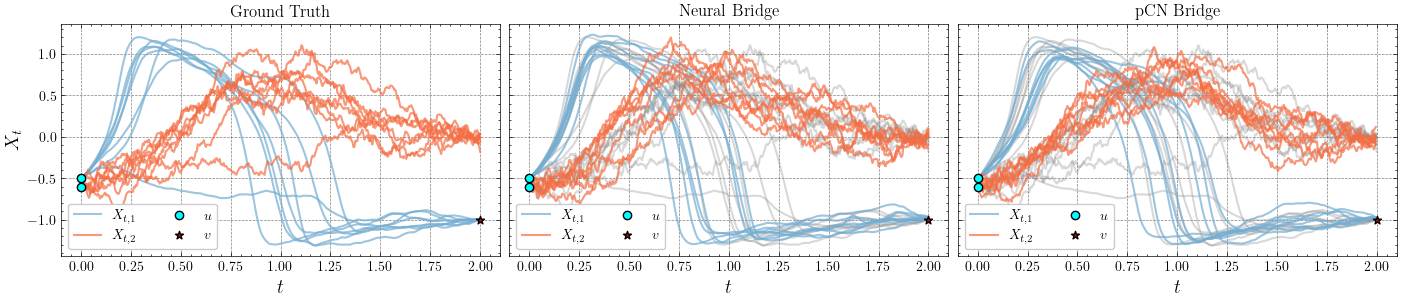

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3), layout="constrained", sharex=True, sharey=True)

plot_sample_path(X_star_path[:8], ax=axes[0], colors=['#74add1', '#f46d43'], label=[r"$X_{t, 1}$", r"$X_{t, 2}$"], title="Ground Truth", linewidth=1.5, zorder=2)
axes[0].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[0].scatter(2.0, v[0], color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].set_xlabel(r"$t$", fontsize=14)
axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].legend(ncol=2)

plot_sample_path(X_star_path[:8], ax=axes[1], colors=["grey", "grey"], alpha=0.3, linewidth=1.5, zorder=1)
plot_sample_path(X_diamond_path[:8], ax=axes[1], colors=['#74add1', '#f46d43'], label=[r"$X_{t, 1}$", r"$X_{t, 2}$"], title="Neural Bridge", linewidth=1.5, zorder=2)
axes[1].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[1].scatter(2.0, v[0], color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[1].set_xlabel(r"$t$", fontsize=14)
axes[1].legend(ncol=2)

plot_sample_path(X_star_path[:8], ax=axes[2], colors=["grey", "grey"], alpha=0.3, linewidth=1.5, zorder=1)
plot_sample_path(X_star_pCN_path[:8], ax=axes[2], colors=['#74add1', '#f46d43'], label=[r"$X_{t, 1}$", r"$X_{t, 2}$"], title="pCN Bridge", linewidth=1.5, zorder=2)
axes[2].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[2].scatter(2.0, v[0], color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[2].set_xlabel(r"$t$", fontsize=14)
axes[2].legend(ncol=2)
fig.savefig("../assets/figures/fhn_model/normal_events_results.pdf", dpi=300, bbox_inches="tight")
plt.show()

### Conditioning on rare event

In [72]:
config = read_config("../configs/fhn_rare.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

{'sde': {'dim': 2, 'T': 2.0, 'dt': 0.005, 'params_X': {'chi': 0.1, 's': 0.0, 'gamma': 1.5, 'alpha': 0.8, 'sigma': 0.3}, 'params_X_tilde': {'chi': 0.1, 's': 0.0, 'gamma': 1.5, 'alpha': 0.8, 'sigma': 0.3, 'v': 1.1}, 'u': [-0.5, -0.6], 'v': [1.1, nan], 'eps': 0.0001}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [32, 32, 32, 32], 'activation': 'tanh'}, 'training': {'save_name': 'fhn_model_rare_partial_obs', 'learning_rate': 0.001, 'batch_size': 32, 'n_iters': 500, 'n_epochs': 20, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


In [73]:
W = WienerProcess(
    T=config.sde.T,
    dt=config.sde.dt,
    shape=(config.sde.dim, ),
)

X = FitzHughNagumoProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde = FitzHughNagumoAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt),
)
X_diamond = neurb.NeuralBridge(
    X_circ=X_circ,
    config=config
)
X_diamond.initialize_solver(W)
_ = X_diamond.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_diamond_path = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=8)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/fhn_model_rare_partial_obs
INFO:root:Loading pretrained model from the last epoch


Pre-conditioned Crank-Nicolson

In [68]:
config = {
    "rho": 0.9,
    "batch_size": 8,
    "n_iters": 50000
}
pCN_model = pCN.PreconditionedCrankNicolson(
    X_circ=X_circ,
    config=config
)
pCN_model.initialize_solver(W)
_, pCN_result = pCN_model.run()
X_star_pCN_path = pCN_result.path

Running pCN: 100%|██████████| 50000/50000 [00:45<00:00, 1097.45it/s]
INFO:root:Batch average acceptance rate: 0.64%


Brutal force sampling to obtain the "ground truth"

In [69]:
X_solver = Euler(X, W)
X_path = X_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=10_000)
# Create masks for each component's end point conditions
x1_mask = (X_path.xs[:, -1, 0] >= v[0] - 1e-2) & (X_path.xs[:, -1, 0] <= v[0] + 1e-2)
final_mask = x1_mask
X_star_path = X_path[final_mask]
print(f"Found {X_star_path.n_samples} samples that satisfy the endpoint conditions out of {X_path.n_samples} samples")

Found 11 samples that satisfy the endpoint conditions out of 10000 samples


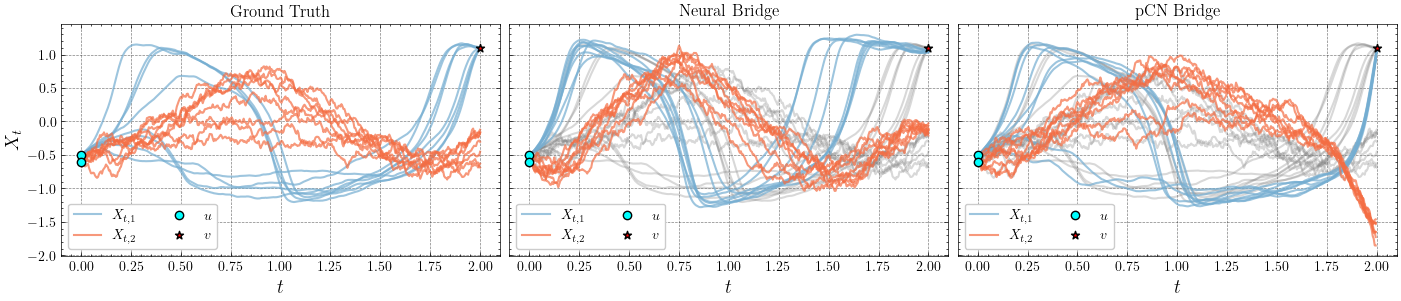

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3), layout="constrained", sharex=True, sharey=True)

plot_sample_path(X_star_path[:8], ax=axes[0], colors=['#74add1', '#f46d43'], label=[r"$X_{t, 1}$", r"$X_{t, 2}$"], title="Ground Truth", linewidth=1.5, zorder=2)
axes[0].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[0].scatter(2.0, v[0], color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[0].set_xlabel(r"$t$", fontsize=14)
axes[0].set_ylabel(r"$X_t$", fontsize=14)
axes[0].legend(ncol=2)

plot_sample_path(X_star_path[:8], ax=axes[1], colors=["grey", "grey"], alpha=0.3, linewidth=1.5, zorder=1)
plot_sample_path(X_diamond_path[:8], ax=axes[1], colors=['#74add1', '#f46d43'], label=[r"$X_{t, 1}$", r"$X_{t, 2}$"], title="Neural Bridge", linewidth=1.5, zorder=2)
axes[1].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[1].scatter(2.0, v[0], color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[1].set_xlabel(r"$t$", fontsize=14)
axes[1].legend(ncol=2)

plot_sample_path(X_star_path[:8], ax=axes[2], colors=["grey", "grey"], alpha=0.3, linewidth=1.5, zorder=1)
plot_sample_path(X_star_pCN_path[:8], ax=axes[2], colors=['#74add1', '#f46d43'], label=[r"$X_{t, 1}$", r"$X_{t, 2}$"], title="pCN Bridge", linewidth=1.5, zorder=2)
axes[2].scatter([0.0, 0.0], u, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[2].scatter(2.0, v[0], color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
axes[2].set_xlabel(r"$t$", fontsize=14)
axes[2].legend(ncol=2)
fig.savefig("../assets/figures/fhn_model/rare_events_results.pdf", dpi=300, bbox_inches="tight")
plt.show()